# 055. 양방향 LSTM을 이용한 개체명 인식

- Named Entity Recognition using Bi-LSTM


- 개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업  (질문 문장의 어절을 일반화시키는 과정에서 개체명(Named Entity) 인식 사전을 활용)


- 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법임  


### BIO 
- B (Begin) - 개체명이 시작되는 부분  
- I (Inside) - 개체명의 내부 부분  
- O (Outside) - 개체명이 아닌 부분


- 각 개체가 어떤 종류인지도 함께 태깅  
```
해 B-movie  
리 I-movie  
포 I-movie  
터 I-movie  
보 O  
러 O  
메 B-theater  
가 I-theater  
박 I-theater  
스 I-theater  
가 O  
자 O  
```



### CoNLL2003 dataset 이용

- CoNLL -  the Conference on Natural Language Learning  


- https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt  에서 download  



- `[word][pos Tagging][chunk tagging][named entity tagging]` 의 4 column 형식으로 구성   


- NE(Named Entity) tagging :   
    LOC - location,   
    ORG - organization,  
    PER - person,   
    MISC - miscellaneous,   
    B - phrase 시작,   
    I - inside phrase,   
    O - phrase 의 일부가 아님
```
The DT B-NP O                             # 개체명 아님               
European NNP I-NP B-ORG            # ORG type phrase 시작 
Commission NNP I-NP I-ORG         # phrase 에 속함 - ORG
said VBD B-VP O                           # 개체명 아님
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC                # MISC type phrase 시작
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP O
to TO B-VP O
shun VB I-VP O
```

## Dataset download 및 전처리

In [1]:
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

- `-DOCSTART- -X- -X- O` 로 file 시작
-  문장 사이는 empty line 으로 구분 

In [2]:
file_path = tf.keras.utils.get_file("train.txt", 
    "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt")

3283420/3283420 [==============================] - 1s 0us/step


In [3]:
for line in open(file_path, 'r').readlines()[:20]:
    print(repr(line))

'-DOCSTART- -X- -X- O\n'
'\n'
'EU NNP B-NP B-ORG\n'
'rejects VBZ B-VP O\n'
'German JJ B-NP B-MISC\n'
'call NN I-NP O\n'
'to TO B-VP O\n'
'boycott VB I-VP O\n'
'British JJ B-NP B-MISC\n'
'lamb NN I-NP O\n'
'. . O O\n'
'\n'
'Peter NNP B-NP B-PER\n'
'Blackburn NNP I-NP I-PER\n'
'\n'
'BRUSSELS NNP B-NP B-LOC\n'
'1996-08-22 CD I-NP O\n'
'\n'
'The DT B-NP O\n'
'European NNP I-NP B-ORG\n'


In [4]:
tagged_sentences = []
sentence = []

for line in open(file_path, 'r'):
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
        
    word, pos_tag, chunk_tag, ner = line.split(' ')   # 공백을 기준으로 속성을 구분 
    ner = re.sub('\n', '', ner)         #['German', 'JJ', 'B-NP', 'B-MISC\n'] 에서 줄바꿈 제거
    word = word.lower()                         # 단어들은 소문자로 바꿔서 저장
    sentence.append((word, ner))                # 단어와 개체명 태깅만 사용

In [5]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력
tagged_sentences[:3]

전체 샘플 개수:  14041


[[('eu', 'B-ORG'),
  ('rejects', 'O'),
  ('german', 'B-MISC'),
  ('call', 'O'),
  ('to', 'O'),
  ('boycott', 'O'),
  ('british', 'B-MISC'),
  ('lamb', 'O'),
  ('.', 'O')],
 [('peter', 'B-PER'), ('blackburn', 'I-PER')],
 [('brussels', 'B-LOC'), ('1996-08-22', 'O')]]

## N to N model

### input, label data 작성을 위해 단어와 tag 를 분리

In [6]:
inputs, labels =[], [] 

for pairs in tagged_sentences:
    words, tags = zip(*pairs)
    inputs.append(list(words))
    labels.append(list(tags))

# Let's see how a sequence looks
print(inputs[0])
print(labels[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


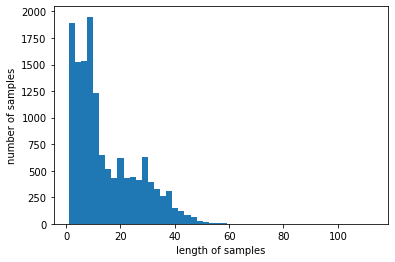

In [7]:
print('샘플의 최대 길이 : {}'.format(max([len(w) for w in inputs])))
print('샘플의 평균 길이 : {:4f}'.format(np.mean([len(w) for w in inputs])))
plt.hist([len(s) for s in inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**sample 들의 길이가 대체적으로 0-40의 길이를 가지며, 특히 0-20의 길이를 가진 샘플이 상당한 비율을 차지**

**keras 는 fixed size sequence 만 handling 가능하므로 max sequence length 를 60 으로 정함**

In [8]:
MAX_LENGTH = 60

### 전체 word 수 check

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(inputs)

print(len(tokenizer.word_index))

21009


전체 token 갯수가 21009 개 이므로 상위 4000 개로 제한하여 vocabulary 재작성하고,  문장 데이터에 대해서는 entity_tokenizer를, 레이블에 해당되는 개체명 태깅 정보에 대해서는 tag_tokenizer를 작성

In [10]:
MAX_WORDS = 4000

### train, test split

In [11]:
train_sentences, test_sentences, train_tags, test_tags \
                = train_test_split(inputs, labels, test_size=0.2)
len(train_sentences), len(test_sentences), len(train_tags), len(test_tags)

(11232, 2809, 11232, 2809)

### word vocabulary 작성

- train data 는 validation set 을 볼 수 없으므로, entity tokenizer는 train_sentences 에 대해서만 tokenize 하고, tag tokenizer 는 전체 labels 에 대해 tokenize 한다.

In [12]:
entity_tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
entity_tokenizer.fit_on_texts(train_sentences)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(labels)

vocab_size = entity_tokenizer.num_words + 1      # MAX_WORDS
tag_size = len(tag_tokenizer.word_index) + 1       #전체 word_index 갯수

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4001
개체명 태깅 정보 집합의 크기 : 10


In [13]:
print(tag_tokenizer.word_index)

{'o': 1, 'b-loc': 2, 'b-per': 3, 'b-org': 4, 'i-per': 5, 'i-org': 6, 'b-misc': 7, 'i-loc': 8, 'i-misc': 9}


### pad sequences  

- sentence 와 tag 를 sequence 로 변환  

In [14]:
X_train = entity_tokenizer.texts_to_sequences(train_sentences)
y_train = tag_tokenizer.texts_to_sequences(train_tags)

X_test = entity_tokenizer.texts_to_sequences(test_sentences)
y_test = tag_tokenizer.texts_to_sequences(test_tags)

len(X_train), len(y_train), len(X_test), len(y_test)

(11232, 11232, 2809, 2809)

In [15]:
X_train[0], y_train[0]

([2462, 10, 51, 1528, 11, 1340, 1, 1, 1, 18, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
X_train_padded = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
y_test_padded  = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')
 
print(X_train_padded[0])
print(X_test_padded[0])
print(y_train_padded[0])
print(y_test_padded[0])

[2462   10   51 1528   11 1340    1    1    1   18    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[  1  55  22  17  49  17 211  17   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
y_train_onehot = to_categorical(y_train_padded, tag_size)
y_test_onehot = to_categorical(y_test_padded, tag_size)

### many-to-many model 이므로 return_sequences=True 로 설정

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         512128    
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        788480    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 10)          5130      
                                                                 
Total params: 1,305,738
Trainable params: 1,305,738
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train_padded, y_train_onehot , batch_size=128, epochs=10, 
              validation_data=(X_test_padded, y_test_onehot))

Epoch 1/10
88/88 [==============================] - 13s 35ms/step - loss: 0.3664 - accuracy: 0.9243 - val_loss: 0.1963 - val_accuracy: 0.9584
Epoch 2/10
88/88 [==============================] - 2s 23ms/step - loss: 0.1677 - accuracy: 0.9595 - val_loss: 0.1335 - val_accuracy: 0.9608
Epoch 3/10
88/88 [==============================] - 2s 23ms/step - loss: 0.1099 - accuracy: 0.9671 - val_loss: 0.0987 - val_accuracy: 0.9697
Epoch 4/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0851 - accuracy: 0.9748 - val_loss: 0.0814 - val_accuracy: 0.9761
Epoch 5/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0671 - accuracy: 0.9806 - val_loss: 0.0650 - val_accuracy: 0.9814
Epoch 6/10
88/88 [==============================] - 2s 24ms/step - loss: 0.0510 - accuracy: 0.9854 - val_loss: 0.0526 - val_accuracy: 0.9849
Epoch 7/10
88/88 [==============================] - 2s 23ms/step - loss: 0.0403 - accuracy: 0.9883 - val_loss: 0.0470 - val_accuracy: 0.9865
Epoch 8/10
8

In [20]:
scores = model.evaluate(X_test_padded, y_test_onehot, verbose=0)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   

accuracy: 98.81333708763123


### test inference

In [21]:
test_sample = ["EU gave German call to take British people"]

In [22]:
test_sample_tokenized = entity_tokenizer.texts_to_sequences(test_sample)
test_sample_padded = pad_sequences(test_sample_tokenized, maxlen=MAX_LENGTH, padding='post')
test_sample_padded

array([[1143,  422,  202,  711,    7,  285,  223,   95,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

In [23]:
index2word =entity_tokenizer.index_word
index2tag = tag_tokenizer.index_word

In [24]:
y_predicted = model.predict(test_sample_padded)
y_pred = y_predicted.argmax(axis=-1)
y_pred

array([[4, 1, 7, 1, 1, 1, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [25]:
test_sample_tokenized

[[1143, 422, 202, 711, 7, 285, 223, 95]]

In [26]:
for i in range(len(test_sample_tokenized)):
    for word, tag in zip([index2word.get(x, '?') for x in test_sample_tokenized[i]], 
                                  [index2tag.get(y, '?') for y in y_pred[i]]):
        if word != '<OOV>' and word != '?' and tag !='?':
            print(f'{word} :  {tag.upper()}')

eu :  B-ORG
gave :  O
german :  B-MISC
call :  O
to :  O
take :  O
british :  B-MISC
people :  O
